<a href="https://colab.research.google.com/github/KiaroRB/data-analysis-projects/blob/main/Taller_practico_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
#TALLER PRÁCTICO - KIARA RODRÍGUEZ BRAVO
!mkdir -p tips-data/csv

In [3]:
!wget -O tips-data/csv/tips.csv https://raw.githubusercontent.com/mwaskom/seaborn-data/master/tips.csv

--2025-11-21 00:46:42--  https://raw.githubusercontent.com/mwaskom/seaborn-data/master/tips.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9729 (9.5K) [text/plain]
Saving to: ‘tips-data/csv/tips.csv’

tips-data/csv/tips. 100%[===================>]   9.50K  --.-KB/s    in 0s      

2025-11-21 00:46:42 (86.3 MB/s) - ‘tips-data/csv/tips.csv’ saved [9729/9729]



In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr, when

spark = SparkSession.builder \
    .appName("TallerTips") \
    .master("local[*]") \
    .getOrCreate()

# Lectura CSV
df = spark.read.option("header", True).option("inferSchema", True).csv("tips-data/csv/tips.csv")

# Ver esquema para asegurar que los tipos son correctos
df.printSchema()
# Ver primeras filas (acción)
df.show(5, truncate=False)


root
 |-- total_bill: double (nullable = true)
 |-- tip: double (nullable = true)
 |-- sex: string (nullable = true)
 |-- smoker: string (nullable = true)
 |-- day: string (nullable = true)
 |-- time: string (nullable = true)
 |-- size: integer (nullable = true)

+----------+----+------+------+---+------+----+
|total_bill|tip |sex   |smoker|day|time  |size|
+----------+----+------+------+---+------+----+
|16.99     |1.01|Female|No    |Sun|Dinner|2   |
|10.34     |1.66|Male  |No    |Sun|Dinner|3   |
|21.01     |3.5 |Male  |No    |Sun|Dinner|3   |
|23.68     |3.31|Male  |No    |Sun|Dinner|2   |
|24.59     |3.61|Female|No    |Sun|Dinner|4   |
+----------+----+------+------+---+------+----+
only showing top 5 rows



In [11]:
#Transformación 1: Filtrar las cuentas mayores a 20 dólares
t1 = df.filter(col("total_bill") > 20)
t1.show(5, truncate=False)
print("Registros después T1:", t1.count())

+----------+----+------+------+---+------+----+
|total_bill|tip |sex   |smoker|day|time  |size|
+----------+----+------+------+---+------+----+
|21.01     |3.5 |Male  |No    |Sun|Dinner|3   |
|23.68     |3.31|Male  |No    |Sun|Dinner|2   |
|24.59     |3.61|Female|No    |Sun|Dinner|4   |
|25.29     |4.71|Male  |No    |Sun|Dinner|4   |
|26.88     |3.12|Male  |No    |Sun|Dinner|4   |
+----------+----+------+------+---+------+----+
only showing top 5 rows

Registros después T1: 97


In [14]:
#Transformación 2: Filtrar solo propinas mayores a 3 dólares
t2 = t1.filter(col("tip") > 3)
t2.show(5, truncate=False)


+----------+----+------+------+---+------+----+
|total_bill|tip |sex   |smoker|day|time  |size|
+----------+----+------+------+---+------+----+
|21.01     |3.5 |Male  |No    |Sun|Dinner|3   |
|23.68     |3.31|Male  |No    |Sun|Dinner|2   |
|24.59     |3.61|Female|No    |Sun|Dinner|4   |
|25.29     |4.71|Male  |No    |Sun|Dinner|4   |
|26.88     |3.12|Male  |No    |Sun|Dinner|4   |
+----------+----+------+------+---+------+----+
only showing top 5 rows



In [16]:
#Transformación 3: Crear una columna con el porcentaje de propina
t3 = t2.withColumn("tip_percentage", (col("tip") / col("total_bill")) * 100)

t3.select("total_bill", "tip", "tip_percentage").show(5, truncate=False)

+----------+----+------------------+
|total_bill|tip |tip_percentage    |
+----------+----+------------------+
|21.01     |3.5 |16.658733936220845|
|23.68     |3.31|13.97804054054054 |
|24.59     |3.61|14.680764538430255|
|25.29     |4.71|18.62396204033215 |
|26.88     |3.12|11.607142857142858|
+----------+----+------------------+
only showing top 5 rows



In [17]:
#Transformación 4: Filtrar mesas de 3 o más personas
t4 = t3.filter(col("size") >= 3)

t4.show(5, truncate=False)
print("Registros después Tranformación 4 mesas con 3 o más personas:", t4.count())

+----------+----+------+------+---+------+----+------------------+
|total_bill|tip |sex   |smoker|day|time  |size|tip_percentage    |
+----------+----+------+------+---+------+----+------------------+
|21.01     |3.5 |Male  |No    |Sun|Dinner|3   |16.658733936220845|
|24.59     |3.61|Female|No    |Sun|Dinner|4   |14.680764538430255|
|25.29     |4.71|Male  |No    |Sun|Dinner|4   |18.62396204033215 |
|26.88     |3.12|Male  |No    |Sun|Dinner|4   |11.607142857142858|
|35.26     |5.0 |Female|No    |Sun|Dinner|4   |14.180374361883155|
+----------+----+------+------+---+------+----+------------------+
only showing top 5 rows

Registros después Tranformación 4 mesas con 3 o más personas: 47


In [18]:
from pyspark.sql.functions import avg

t4.select(avg("tip_percentage").alias("avg_tip_pct")).show()


+------------------+
|       avg_tip_pct|
+------------------+
|15.957380018318077|
+------------------+



In [19]:
#Transformación 5: Clasificar propinas como “Altas” o “Bajas”
t5 = t4.withColumn("tip_class", when(col("tip_percentage") >= 18, "Alta").otherwise("Baja"))

t5.select("total_bill", "tip", "tip_percentage", "size", "tip_class").show(10, truncate=False)


+----------+----+------------------+----+---------+
|total_bill|tip |tip_percentage    |size|tip_class|
+----------+----+------------------+----+---------+
|21.01     |3.5 |16.658733936220845|3   |Baja     |
|24.59     |3.61|14.680764538430255|4   |Baja     |
|25.29     |4.71|18.62396204033215 |4   |Alta     |
|26.88     |3.12|11.607142857142858|4   |Baja     |
|35.26     |5.0 |14.180374361883155|4   |Baja     |
|20.65     |3.35|16.222760290556902|3   |Baja     |
|39.42     |7.58|19.228817858954844|4   |Alta     |
|24.06     |3.6 |14.962593516209477|3   |Baja     |
|31.27     |5.0 |15.98976654940838 |3   |Baja     |
|30.4      |5.6 |18.421052631578945|4   |Alta     |
+----------+----+------------------+----+---------+
only showing top 10 rows



In [20]:
# Explicación del plan
t5.explain(extended=True)
t5.explain()

== Parsed Logical Plan ==
'Project [total_bill#17, tip#18, sex#19, smoker#20, day#21, time#22, size#23, tip_percentage#310, CASE WHEN ('tip_percentage >= 18) THEN Alta ELSE Baja END AS tip_class#412]
+- Filter (size#23 >= 3)
   +- Project [total_bill#17, tip#18, sex#19, smoker#20, day#21, time#22, size#23, ((tip#18 / total_bill#17) * cast(100 as double)) AS tip_percentage#310]
      +- Filter (tip#18 > cast(3 as double))
         +- Filter (total_bill#17 > cast(20 as double))
            +- Relation [total_bill#17,tip#18,sex#19,smoker#20,day#21,time#22,size#23] csv

== Analyzed Logical Plan ==
total_bill: double, tip: double, sex: string, smoker: string, day: string, time: string, size: int, tip_percentage: double, tip_class: string
Project [total_bill#17, tip#18, sex#19, smoker#20, day#21, time#22, size#23, tip_percentage#310, CASE WHEN (tip_percentage#310 >= cast(18 as double)) THEN Alta ELSE Baja END AS tip_class#412]
+- Filter (size#23 >= 3)
   +- Project [total_bill#17, tip#18, se

/tmp/ipython-input-911831752.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


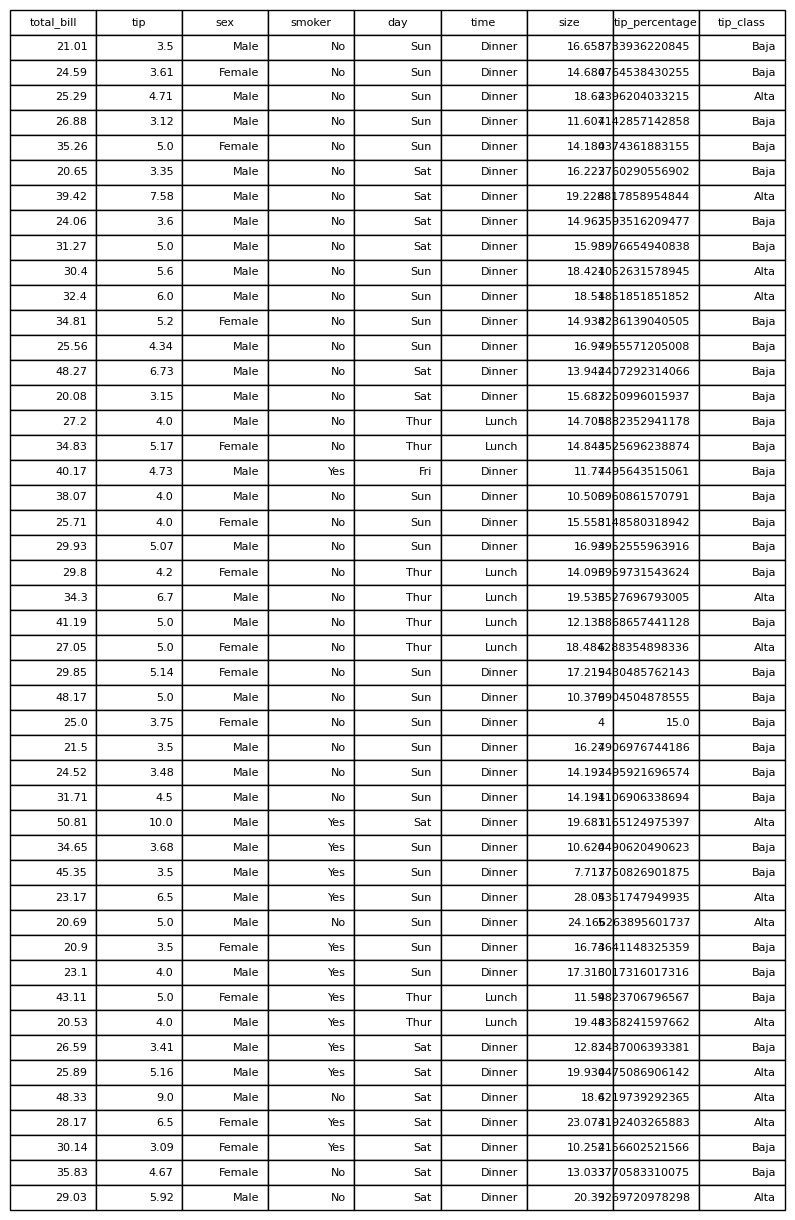

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertimos una pequeña muestra a pandas (acción)
sample_pd = t5.limit(50).toPandas()

# Crear figura con tabla
fig, ax = plt.subplots(figsize=(10,6))
ax.axis('off')
table = ax.table(cellText=sample_pd.values, colLabels=sample_pd.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1, 1.5)
plt.tight_layout()
plt.savefig("tips_report_sample.pdf")
